<a href="https://colab.research.google.com/github/eguzmanv/Hypocenter-cross-sections/blob/main/hypo_xsects_COLAB.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Prepare colab

In [1]:
import sys

if 'google.colab' in sys.modules:
  ! git clone "https://github.com/eguzmanv/Hypocenter-cross-sections.git"

Cloning into 'Hypocenter-cross-sections'...
remote: Enumerating objects: 107, done.
remote: Counting objects: 100% (107/107), done.
remote: Compressing objects: 100% (75/75), done.
remote: Total 107 (delta 47), reused 82 (delta 30), pack-reused 0
Receiving objects: 100% (107/107), 3.37 MiB | 7.99 MiB/s, done.
Resolving deltas: 100% (47/47), done.


In [2]:
! pip install obspy

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.5/14.5 MB 40.6 MB/s eta 0:00:00


Please restart kernel before running.

In [1]:
import os
import sys
import random
import warnings

import numpy as np

import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

if 'google.colab' in sys.modules:
    repo_fpath = "/content/Hypocenter-cross-sections"
else:
    repo_fpath = os.getcwd()
sys.path.append(repo_fpath)
from utils.xsects import *

warnings.filterwarnings('ignore')

# I. Initial considerations

This notebook focuses on generating cross sections. We'll learn an easy way to:

1. Project a hypocenter onto a section line
2. Obtain the section coordinates (i.e. the 4 coordinates of the polygon/rectangle)
3. Write a file with the projection data

Furthermore, we will explore the most powerful tool in this section:

4. Obtain $n$ contiguous cross sections of a desired width $d$

**Data**

For our example, we will be working with a relocated event dataset:

- *Relocated catalog (1735 events) : reloc_data.txt

<small>*Earthquake data source: Hauksson, E. and W. Yang, and P.M. Shearer, "Waveform Relocated Earthquake Catalog for Southern California (1981 to 2011)"; Bull. Seismol. Soc. Am., Vol. 102, No. 5, pp.2239-2244, October 2012, doi: 10.1785/0120120010.

Link: https://scedc.caltech.edu/data/alt-2011-dd-hauksson-yang-shearer.html

</small>

Let's get started! We will begin by importing the relocated catalog as a NumPy array. The columns are organized in the following format:

<p style="text-align: center;">[ID, longitude (deg), latitude (deg), depth (km), magnitude]</p>

In [2]:
reloc_cat = np.genfromtxt(fname = os.path.join(repo_fpath, 'event_data/reloc_cat.txt'), skip_header = 1)
reloc_cat[:5]

array([[ 1.4567444e+07, -1.1542500e+02,  3.2749000e+01,  1.1090000e+01,
         1.3000000e+00],
       [ 1.4567452e+07, -1.1542400e+02,  3.2749000e+01,  1.0800000e+01,
         1.7000000e+00],
       [ 1.4567964e+07, -1.1540600e+02,  3.2745000e+01,  1.1310000e+01,
         1.2000000e+00],
       [ 1.4568588e+07, -1.1541900e+02,  3.2750000e+01,  1.1120000e+01,
         1.6000000e+00],
       [ 1.4568620e+07, -1.1541800e+02,  3.2749000e+01,  1.1230000e+01,
         2.5000000e+00]])

Let's graph the events:

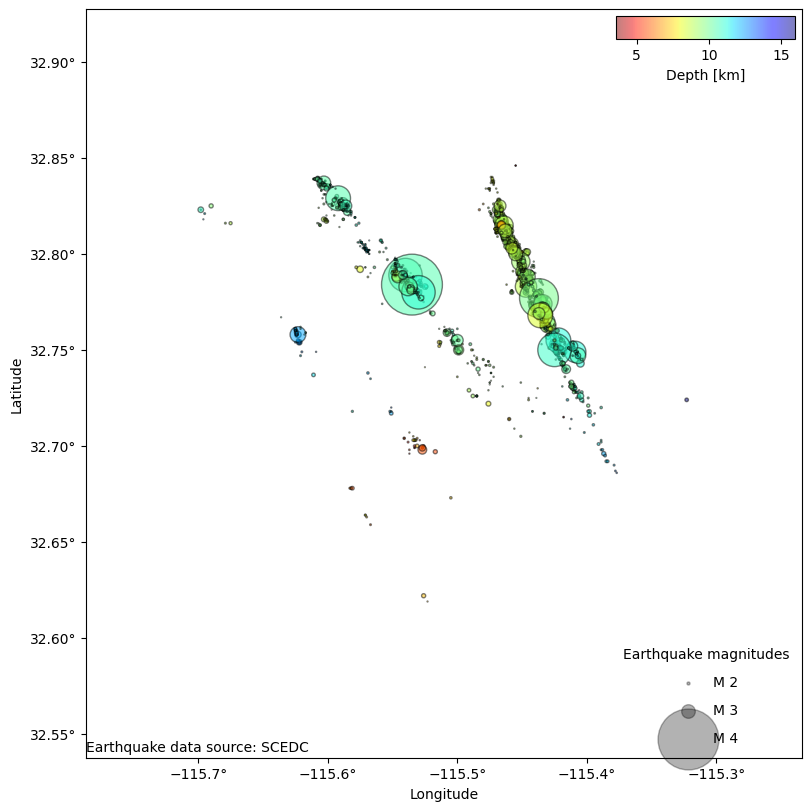

In [3]:
# Figure
fig = plt.figure(figsize = (8, 8), layout = 'constrained')
    # Subplots
ax1 = fig.add_subplot(111)
    # Labels
ax1.set_xlabel('Longitude')                                 # x
ax1.set_ylabel('Latitude')                                  # y
    # Plot event data
plt.scatter(x = reloc_cat[:, 1],
            y = reloc_cat[:, 2],
            c = reloc_cat[:, 3], cmap = 'jet_r',
            s = 0.012 * (20 ** reloc_cat[:, 4]),
            edgecolors = 'k',
            alpha = 0.5)
    # Axis lims
xlim = ax1.get_xlim()
ylim = ax1.get_ylim()
ax1.set_xlim([xlim[0] - 0.07, xlim[1] + 0.07])
ax1.set_ylim([ylim[0] - 0.07, ylim[1] + 0.07])
    # Axis tick labels
fig.canvas.draw()
    # x
xlabels = [f'{item.get_text()}°' for item in ax1.get_xticklabels()]
ax1.set_xticklabels(xlabels)
    # y
ylabels = [f'{item.get_text()}°' for item in ax1.get_yticklabels()]
ax1.set_yticklabels(ylabels)
    # Color bar
cbaxes = inset_axes(ax1, width = "25%", height = "3%", loc = 1)
plt.colorbar(cax = cbaxes, ticks = [1, 5, 10, 15, 20], orientation = 'horizontal', label = 'Depth [km]')

    # Legend
for mag in [2, 3, 4]:
    ax1.scatter([], [], c = 'k', alpha = 0.3, s = 0.012 * (20 ** mag), label = f'M {mag}')
ax1.legend(scatterpoints = 1, frameon = False, labelspacing = 1, title = 'Earthquake magnitudes',
           loc = 4)
# plt.rcParams['legend.title_fontsize'] = 'large'
ax1.text(0, .005, s = 'Earthquake data source: SCEDC',
         horizontalalignment = 'left',verticalalignment = 'bottom',
         transform = ax1.transAxes, fontsize = 'medium')
fig.savefig(os.path.join(repo_fpath,'figs/0.jpg'), dpi = 300)
plt.show()

Now let's import the class we'll use:

In [4]:
xsect = Xsections()

# 2. Calculate the projection of an event onto a cross-section line

A cross section is defined by:

- A line formed by two coordinates:
    - $p1$: (x1, y1)
    - $p2$: (x2, y2)
- A secion width $d$ (km)

**Example:**

Let's select a random event and define a line formed by points $p1$ and $p2$:

In [5]:
# Random event
ev_row   = random.choice(range(len(reloc_cat)))
    # Epicenter
lon, lat = reloc_cat[ev_row, 1], reloc_cat[ev_row, 2]
    # Point to project
p        = (lon, lat)                                    # (x, y) [degrees]

# Section line
p1 = (-115.7, 32.65)                                     # [degrees]
p2 = (-115.3, 32.85)                                     # [degrees]

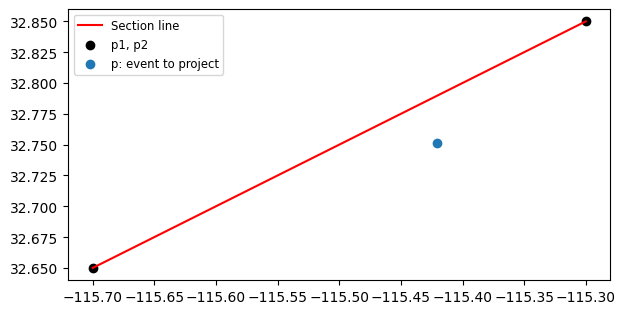

In [6]:
# Plot
fig = plt.figure(figsize = (7, 7))
    # Section line
plt.plot([p1[0], p2[0]], [p1[1], p2[1]], 'r', label = 'Section line')
        # p1, p2
plt.scatter(x = p1[0], y = p1[1], c = 'k', label = 'p1, p2')
plt.scatter(x = p2[0], y = p2[1], c = 'k')
    # Event to project
plt.scatter(x = p[0], y = p[1], label = 'p: event to project')
plt.legend(loc = 0, fontsize = 'small')
    # Plot equal scale between axis
plt.gca().set_aspect('equal', adjustable='box')
plt.show()

The following function returns the coordinates and magnitude of projection:

In [7]:
help(xsect.orthogonal_projection)

Help on method orthogonal_projection in module utils.xsects:

orthogonal_projection(p1: tuple, p2: tuple, p: tuple) method of utils.xsects.Xsections instance
    - Description     : Compute the orthogonal projection of a given point (p) on a line 
                        (line defined by p1 and p2 coordinates).
    - Input parameters:
        <<< p1        : tuple
                        Coordinates of point 1 (x1, y1) of section
        <<< p2        : tuple 
                        Coordinates of point 2 (x2, y2) of section
        <<< p         : tuple
                        Point to project on the line
    - Returns         :
        >>> proj      : np.ndarray
                        Projection coordinates
        >>> proj_dist : int, float
                        Projection magnitude [deg] from p1 (westermost 
                        point on line) to proj.



In [8]:
proj, proj_dist = xsect.orthogonal_projection(p1, p2, p)
proj, proj_dist

(array([-115.4364,   32.7818]), 0.2947137594344686)

Result:


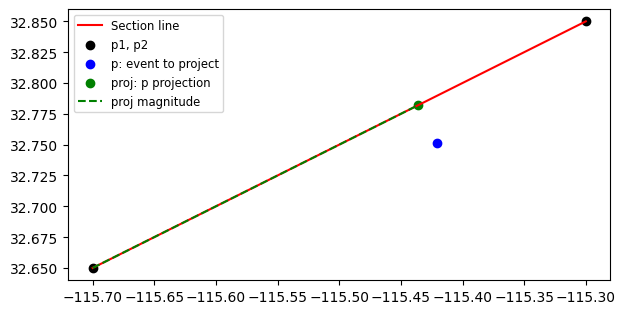

In [9]:
# Plot
fig = plt.figure(figsize = (7, 7))
    # Section line
plt.plot([p1[0], p2[0]], [p1[1], p2[1]], c = 'r', label = 'Section line')
        # p1, p2
plt.scatter(x = p1[0], y = p1[1], c = 'k', label = 'p1, p2')
plt.scatter(x = p2[0], y = p2[1], c = 'k')
    # Event to project
plt.scatter(x = p[0], y = p[1], c = 'b', label = 'p: event to project')
    # Projection
plt.scatter(x = proj[0], y = proj[1], c = 'green', label = 'proj: p projection')
        # Magnitude of projection
plt.plot([p1[0], proj[0]], [p1[1], proj[1]], ls = '--', c = 'green', label = 'proj magnitude')
plt.legend(loc = 0, fontsize = 'small')
    # Plot equal scale between axis
plt.gca().set_aspect('equal', adjustable = 'box')
plt.show()

# 3. Obtaining the 4 coordinates of the polygon for a cross-section of width $d$

In this step, we will determine the coordinates of cross-section polygon. We have already defined $p1$ and $p2$. Now, we need to specify the section width $d$ in kilometers:

In [10]:
d = 5                 # [km]

The following function takes $p1$, $p2$ and $d$ as input parameters and it returns:
- The 4 corner coordinates of the polygon
- A polygon object (if *return_pol* parameter is set to True): This output will be useful for checking if an event is inside of the polygon.

In [11]:
help(xsect.get_rect_coordinates)

Help on method get_rect_coordinates in module utils.xsects:

get_rect_coordinates(p1: tuple, p2: tuple, d, return_pol=False) method of utils.xsects.Xsections instance
    - Description     : Get coordinates of rectangle polygon based on the two 
                        coordinates of section.
    - Input parameters:
        <<< p1        : tuple
                        Coordinates of point 1 (x1, y1) of section
        <<< p2        : tuple 
                        Coordinates of point 2 (x2, y2) of section
        <<< d         : int, float
                        Section width [km]
    - Returns         :
        >>> coord_list: list
                        List of 4 tuples. Each tuple is composed of (x, y)
                        coordinates.
        >>> return_pol: bool, default = False
                        Return polygon object (shapely.geometry.polygon.Polygon)



Let's see an example using the defined $p1$, $p2$ and $d$:

In [12]:
rect_coords = xsect.get_rect_coordinates(p1, p2, d)
rect_coords

[(-115.69069206898779, 32.62953418668689),
 (-115.70930793101222, 32.67046581331311),
 (-115.30931143992039, 32.87046421708505),
 (-115.2906885600796, 32.82953578291495)]

As you can see, 4 tuples are returned. Let's see what happens when we request the polygon object:

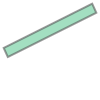

In [13]:
rect_coords, pol = xsect.get_rect_coordinates(p1, p2, d, return_pol = True)
pol

Let's visualize how our polygon appears in the previous figure:

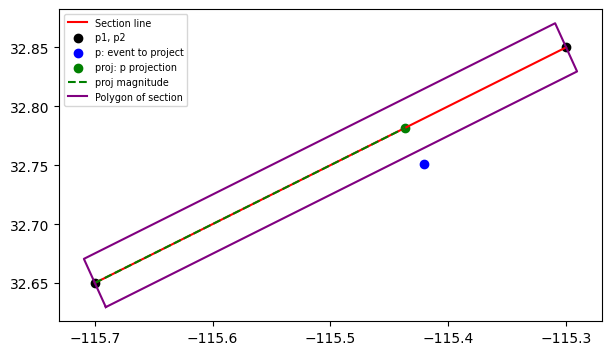

In [14]:
# Plot
fig = plt.figure(figsize = (7, 7))
    # Section line
plt.plot([p1[0], p2[0]], [p1[1], p2[1]], c = 'r', label = 'Section line')
        # p1, p2
plt.scatter(x = p1[0], y = p1[1], c = 'k', label = 'p1, p2')
plt.scatter(x = p2[0], y = p2[1], c = 'k')
    # Event to project
plt.scatter(x = p[0], y = p[1], c = 'b', label = 'p: event to project')
    # Projection
plt.scatter(x = proj[0], y = proj[1], c = 'green', label = 'proj: p projection')
        # Magnitude of projection
plt.plot([p1[0], proj[0]], [p1[1], proj[1]], ls = '--', c = 'green', label = 'proj magnitude')
    # Polygon
x, y = pol.exterior.xy
plt.plot(x, y, color = 'purple', label = 'Polygon of section')
    # Legend
plt.legend(loc = 0, fontsize = 'x-small')
    # Plot equal scale between axis
plt.gca().set_aspect('equal', adjustable = 'box')
plt.show()

The polygon is formed by 4 corner coordinates ($rect\_coords$). Now, with this polygon defined, we're now able to:

1. Check if a set of events is inside the polygon.
2. Calculate the projection of each event onto the cross-section line.
3. Save the projection data (next step)

# 4. Save projection data

The most effective way to save the projection data is by considering the functional parameters that we'll need in our plots:

- ID
- Event location (longitude, latitude, depth)
- Magnitude (if necessary for plotting event sizes)
- Projection coordinates on section line
- Magnitude of projection from p1 (westernmost point) to projected point

The following function will help us in achieving this:

In [15]:
help(xsect.write_cross_data)

Help on method write_cross_data in module utils.xsects:

write_cross_data(fpath: str, cat, polygon, p1, p2) method of utils.xsects.Xsections instance
    - Description     : Save cross projection data.
    - Input parameters:
        <<< fpath     : str
                        File path to save the data.
        <<< cat       : np.ndarray
                        Catalog. Numpy array composed of:
                        [ID, lon [deg], lat[deg], depth [km], magnitude]
        <<< polygon   : shapely.geometry.polygon.Polygon
                        Polygon object returned by get_rect_coordinates()
        <<< p1        : tuple
                        Coordinates of point 1 (x1, y1) of section
        <<< p2        : tuple 
                        Coordinates of point 2 (x2, y2) of section
    - Output          : .dat file
                        File with the following header
                        [orid, lon[deg], lat[deg], depth[km], mag[ML], 
                        *lon_proj[deg], *

Prior to saving the projection data, we need to ensure that we're saving all the events that fall within our polygon, i.e., all the events inside the purple polygon:

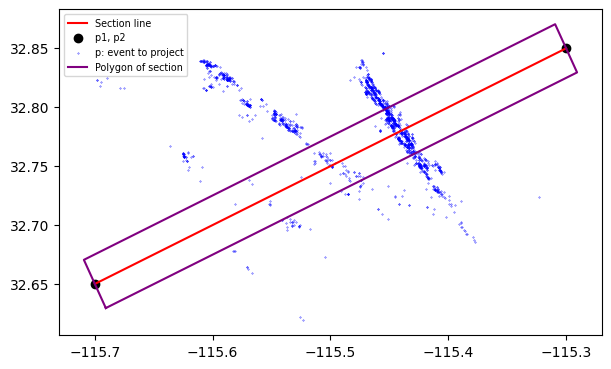

In [16]:
# Plot
fig = plt.figure(figsize = (7, 7))
    # Section line
plt.plot([p1[0], p2[0]], [p1[1], p2[1]], c = 'r', label = 'Section line')
        # p1, p2
plt.scatter(x = p1[0], y = p1[1], c = 'k', label = 'p1, p2')
plt.scatter(x = p2[0], y = p2[1], c = 'k')
    # Event to project
plt.scatter(x = reloc_cat[:, 1], y = reloc_cat[:, 2], c = 'b', s = 0.08, label = 'p: event to project')
    # Polygon
x, y = pol.exterior.xy
plt.plot(x, y, color = 'purple', label = 'Polygon of section')
    # Legend
plt.legend(loc = 0, fontsize = 'x-small')
    # Plot equal scale between axis
plt.gca().set_aspect('equal', adjustable='box')
plt.show()

Now, we're ready to save the projection data:

In [18]:
xsect.write_cross_data(fpath = os.path.join(repo_fpath,'cross_section_data/cross_test.dat'), cat = reloc_cat, polygon = pol, p1 = p1, p2 = p2)

and this is what our first cross section looks like:

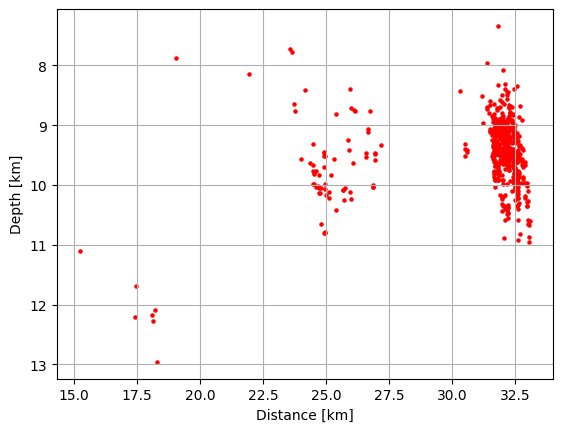

In [19]:
# Load cross section data
reloc_cross_data = np.genfromtxt(os.path.join(repo_fpath,'cross_section_data/cross_test.dat'), skip_header = 1)
# Plot
    # Data
x_km = reloc_cross_data[:, 8]                                  # Distance [km] between p1 (westernmost point) to projected point
z    = reloc_cross_data[:, 3]                                  # Depth
plt.scatter(x = x_km, y = z, c = 'red', marker = 'o', s = 5.)
        # Invert z axis (positive depths)
plt.gca().invert_yaxis()
    # Axis labels
plt.xlabel('Distance [km]')
plt.ylabel('Depth [km]')
plt.grid()
plt.show()

# 5. Generate multiple cross sections

We have now reached the most useful step. Before we learn how to use the following function, I would like to provide you some tips:

- Estimate the *strike* of the structure of interest for better cross sections. If you are unsure about this information and your point cloud can approximate a plane, you can estimate the **strike** using various math methods.
- Always remember that the set of sections will be generate from **west to east**, i.e., **the first cross section proposed should be the westermost section of the set**.
- We need to select:
    - An initial $p1$ point
    - The azimuth of the cross sections ($az$) (measured from north direction).
    - The number of sections ($n$)
    - The section width ($d$) in kilometers
    - The section length ($sect\_length$) in kilometers (measured from $p1$ with azimuth $az$).

The function that will help us whit this is:

In [20]:
help(xsect.get_section_coordinates_list)

Help on method get_section_coordinates_list in module utils.xsects:

get_section_coordinates_list(p1, az, sect_length, n, d, x_move=0, y_move=0) method of utils.xsects.Xsections instance
    - Description           : Compute list of coordinates of n cross sections.
    - Input parameters      : 
        <<< p1              : tuple, list
                              Suggested initial coordinate (x, y).
        <<< az              : int, float
                              Azimuth of cross section [degrees]. 0° and 360° are the north direction.
        <<< sect_length     : int, float
                              Cross section length [km] (measured from p1)
        <<< n               : int
                              Number of cross sections from west to east
        <<< d               : int, float
                              Section width [km]
        <<< x_move          : int, float, default = 0
                              Proposed movement of cross sections in x direction [d

As we can infer from the previous steps, we need to generate a set of contiguous *rect_coords*. Let's explore some examples:

**Example 1:**

Generate a set of 8 contiguous cross sections of width 4 km (i.e. 2km|2km), length of 20 km, and azimuth 54°:

In [21]:
# Azimuth
az          = 54                     # [degrees]
# Section width
d           = 4                      # [km]
# Section length
sect_length = 20                     # [km]
# Number of sections
n           = 8
# p1
p1 = (-115.63, 32.80)                # (x, y)

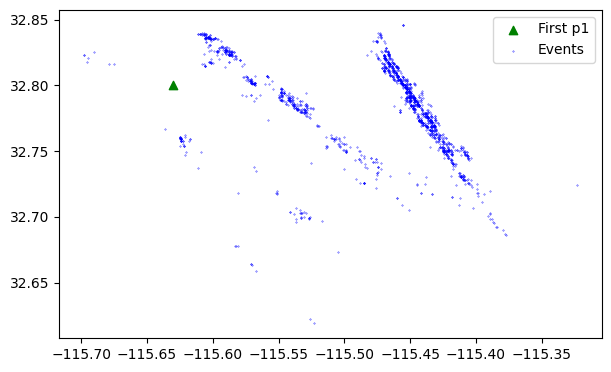

In [22]:
# Plot
fig = plt.figure(figsize = (7, 7))
    # p1
plt.scatter(x = p1[0], y = p1[1], c = 'g', marker = '^', label = 'First p1')
    # Events
plt.scatter(x = reloc_cat[:, 1], y = reloc_cat[:, 2], c = 'b', s = 0.08, label = 'Events')
    # Legend
plt.legend(loc = 0)
    # Plot equal scale between axis
plt.gca().set_aspect('equal', adjustable='box')
plt.show()

Now let's use the above function:

In [23]:
sect_coord_list = xsect.get_section_coordinates_list(p1 = p1, az = az, sect_length = sect_length, n = n, d = d)
sect_coord_list

[[(-115.63, 32.8), (-115.49353684128236, 32.917170731617134)],
 [(-115.60770805340756, 32.77176675579188),
  (-115.47124190090781, 32.88893985144859)],
 [(-115.58541615626163, 32.743533472542666),
  (-115.4489470099224, 32.860708932275735)],
 [(-115.56312430856258, 32.71530015025219),
  (-115.42665216832656, 32.83247797409839)],
 [(-115.54083251031082, 32.687066788920276),
  (-115.40435737612066, 32.80424697691637)],
 [(-115.51854076150677, 32.65883338854674),
  (-115.38206263330511, 32.7760159407295)],
 [(-115.49624906215081, 32.63059994913141),
  (-115.35976793988031, 32.74778486553762)],
 [(-115.47395741224335, 32.60236647067411),
  (-115.33747329584666, 32.71955375134054)]]

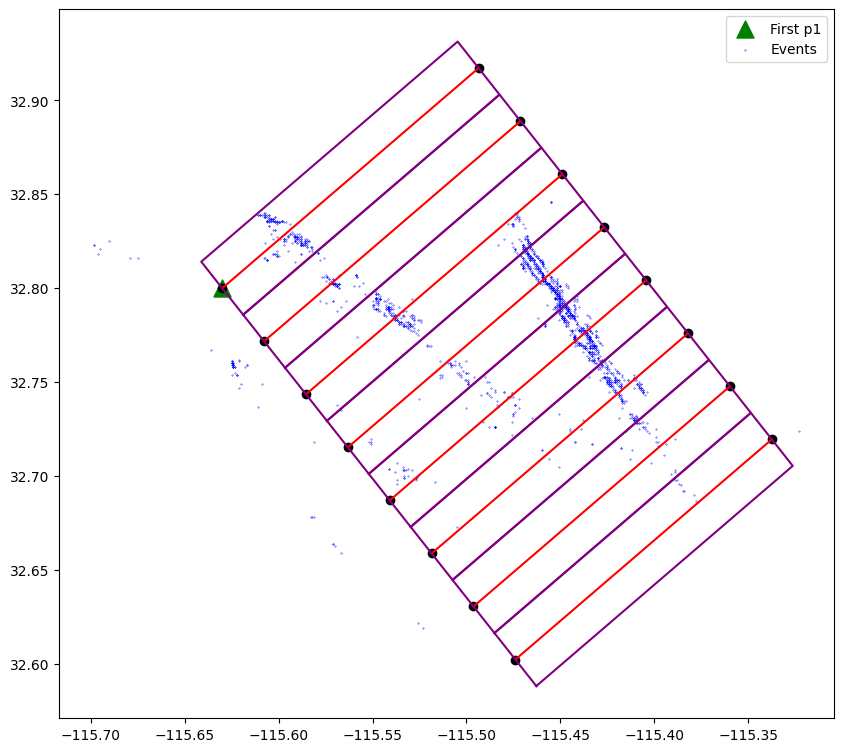

In [24]:
# Plot
fig = plt.figure(figsize = (10, 10))
    # p1
plt.scatter(x = p1[0], y = p1[1], c = 'g', marker = '^', s = 150, label = 'First p1')
    # Event
plt.scatter(x = reloc_cat[:, 1], y = reloc_cat[:, 2], c = 'b', s = 0.08, label = 'Events')
    # Polygons
for coord_pair in sect_coord_list:
        # Section coordinates
    p1_, p2_ = sorted(coord_pair, key = lambda x:x[0])
            # Plot section lines and p1_, p2_
    plt.plot([p1_[0], p2_[0]], [p1_[1], p2_[1]], c = 'r')
    plt.scatter(x = p1_[0], y = p1_[1], c = 'k')
    plt.scatter(x = p2_[0], y = p2_[1], c = 'k')
        # Section polygon
            # Coordinates and polygon object
    rect_coord, pol = xsect.get_rect_coordinates(p1_, p2_, d = d, return_pol = True)
    x, y = pol.exterior.xy
    plt.plot(x, y, color = 'purple')
    # Legend
plt.legend(loc = 0)
    # Plot equal scale between axis
plt.gca().set_aspect('equal', adjustable='box')
plt.show()

**Example 2**:

Generate a set of 8 contiguous cross sections of width 2 km (i.e. 1km|1km), a length of 30 km, and azimuth 144°:

In [25]:
# Azimuth
az          = 144                     # [degrees]
# Section width
d           = 2                      # [km]
# Section length
sect_length = 30                     # [km]
# Number of sections
n           = 8
# p1
p1 = (-115.63, 32.86)                # (x, y)

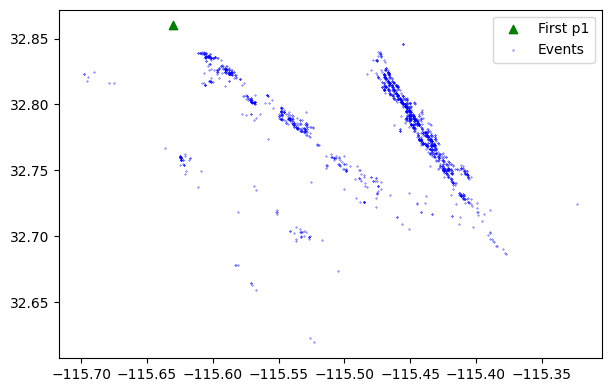

In [26]:
# Plot
fig = plt.figure(figsize = (7, 7))
    # p1
plt.scatter(x = p1[0], y = p1[1], c = 'g', marker = '^', label = 'First p1')
    # Events
plt.scatter(x = reloc_cat[:, 1], y = reloc_cat[:, 2], c = 'b', s = 0.08, label = 'Events')
    # Legend
plt.legend(loc = 0)
    # Plot equal scale between axis
plt.gca().set_aspect('equal', adjustable='box')
plt.show()

Now, let's plot our set of cross sections:

In [27]:
sect_coord_list = xsect.get_section_coordinates_list(p1 = p1, az = az, sect_length = sect_length, n = n, d = d)
sect_coord_list

[[(-115.63, 32.86), (-115.48165991676568, 32.634643923346765)],
 [(-115.61572967688898, 32.87094849846582),
  (-115.46738736754199, 32.64558951967617)],
 [(-115.60145937526916, 32.881897024943314),
  (-115.45311483977898, 32.65653514398924)],
 [(-115.58718909514067, 32.89284557943254),
  (-115.43884233347677, 32.66748079628603)],
 [(-115.57291883650366, 32.90379416193356),
  (-115.42456984863551, 32.67842647656662)],
 [(-115.55864859935828, 32.91474277244646),
  (-115.41029738525535, 32.68937218483108)],
 [(-115.54437838370465, 32.9256914109713),
  (-115.3960249433364, 32.70031792107947)],
 [(-115.53010818954291, 32.936640077508144),
  (-115.38175252287883, 32.711263685311856)]]

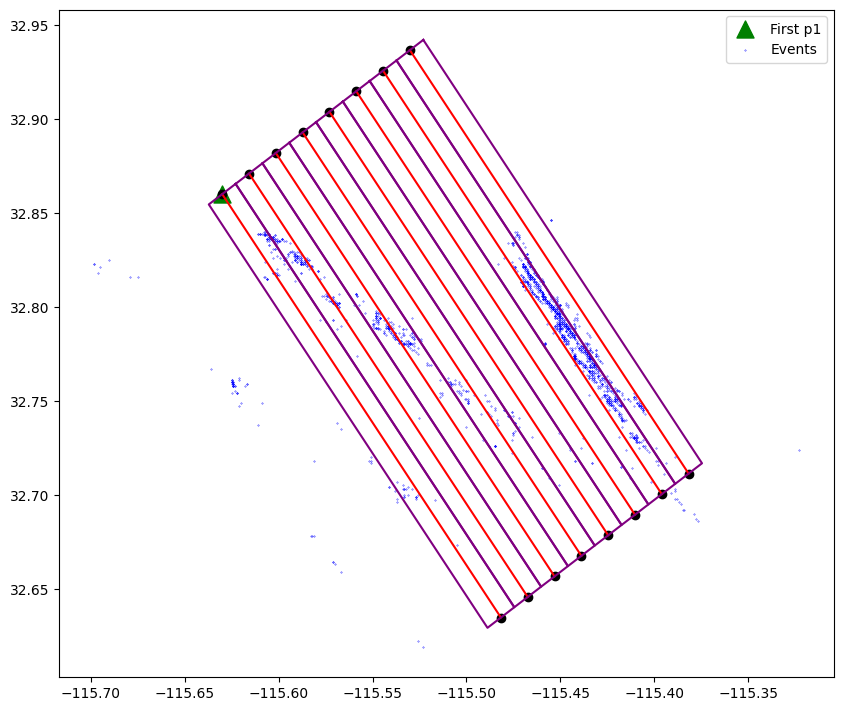

In [28]:
# Plot
fig = plt.figure(figsize = (10, 10))
    # p1
plt.scatter(x = p1[0], y = p1[1], c = 'g', marker = '^', s = 150, label = 'First p1')
    # Event
plt.scatter(x = reloc_cat[:, 1], y = reloc_cat[:, 2], c = 'b', s = 0.08, label = 'Events')
    # Polygons
for coord_pair in sect_coord_list:
        # Section coordinates
    p1_, p2_ = sorted(coord_pair, key = lambda x:x[0])
            # Plot section lines and p1_, p2_
    plt.plot([p1_[0], p2_[0]], [p1_[1], p2_[1]], c = 'r')
    plt.scatter(x = p1_[0], y = p1_[1], c = 'k')
    plt.scatter(x = p2_[0], y = p2_[1], c = 'k')
        # Section polygon
            # Coordinates and polygon object
    rect_coord, pol = xsect.get_rect_coordinates(p1_, p2_, d = d, return_pol = True)
    x, y = pol.exterior.xy
    plt.plot(x, y, color = 'purple')
    # Legend
plt.legend(loc = 0)
    # Plot equal scale between axis
plt.gca().set_aspect('equal', adjustable = 'box')
plt.show()

# 6. Final example: let's compile everything we have learned

Now that we have covered how to project events, generate cross-section polygons and save the data, let's put everything together and generate a set of cross sections as a final example:

First, we'll plot all the cross sections and save their projection data.

Plotting event locations ...
Plotting section polygons ...
   -> A1 ...
   -> A2 ...
   -> A3 ...
   -> A4 ...
   -> A5 ...
   -> A6 ...
   -> A7 ...
   -> A8 ...
   -> B1 ...
   -> B2 ...
   -> B3 ...
   -> B4 ...
   -> B5 ...
   -> B6 ...
   -> B7 ...
   -> B8 ...


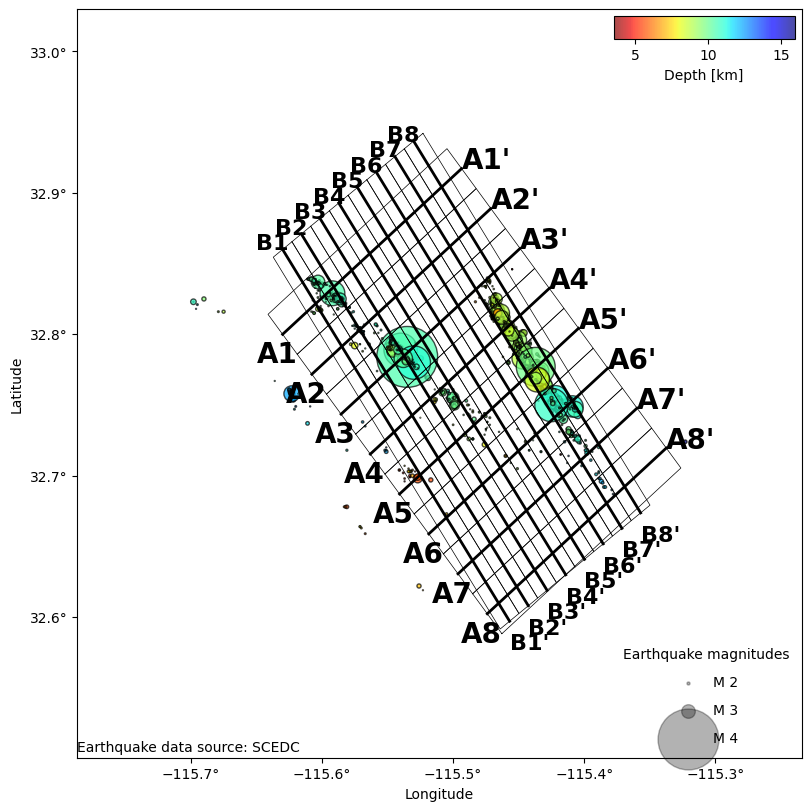

In [29]:
# Figure
fig = plt.figure(figsize = (8, 8), layout = 'constrained')
    # ----------- Subplots -----------
ax1 = fig.add_subplot(111)
    # ----------- Labels -----------
ax1.set_xlabel('Longitude')                                 # x
ax1.set_ylabel('Latitude')                                  # y
    # ----------- Plot event data -----------
print('Plotting event locations ...')
plt.scatter(x = reloc_cat[:, 1],
            y = reloc_cat[:, 2],
            c = reloc_cat[:, 3], cmap = 'jet_r',
            s = 0.012 * (20 ** reloc_cat[:, 4]),
            edgecolors = 'k',
            alpha = 0.7)
    #  ----------- Plot polygons -----------
print('Plotting section polygons ...')
        # A cross sections
d = 4 # [km]
A_sect_coord_list = xsect.get_section_coordinates_list(p1 = (-115.63, 32.80), az = 54, sect_length = 20, n = 8, d = d)
for n, coord_pair in zip(range(1, len(A_sect_coord_list) + 1), A_sect_coord_list):
    print(f'   -> A{n} ...')
        # Section coordinates
    p1_, p2_ = sorted(coord_pair, key = lambda x:x[0])
        # Section line
    plt.plot([p1_[0], p2_[0]], [p1_[1], p2_[1]], c = 'k', lw = 2)
    plt.text(x = p1_[0] - 0.02, y = p1_[1] - 0.02, s = f'A{n}', fontsize = 20, fontweight = 'bold')
    plt.text(x = p2_[0] + 0, y = p2_[1] + 0, s = f"A{n}'", fontsize = 20, fontweight = 'bold')
        # Section polygon
            # Coordinates and polygon object
    rect_coord_list, pol = xsect.get_rect_coordinates(p1_, p2_, d = d, return_pol = True)
    x, y = pol.exterior.xy
    plt.plot(x, y, color = 'k', lw = 0.5)
        # Write cross data
    xsect.write_cross_data(fpath = os.path.join(repo_fpath,f'cross_section_data/A{n}.dat'),
                           cat = reloc_cat, polygon = pol, p1 = p1_, p2 = p2_)

        # B cross sections
d = 2 # [km]
B_sect_coord_list = xsect.get_section_coordinates_list(p1 = (-115.63, 32.86), az = 144, sect_length = 35, n = 8, d = d)

for n, coord_pair in zip(range(1, len(B_sect_coord_list) + 1), B_sect_coord_list):
    print(f'   -> B{n} ...')
        # Section coordinates
    p1_, p2_ = sorted(coord_pair, key = lambda x:x[0])
        # Section line
    plt.plot([p1_[0], p2_[0]], [p1_[1], p2_[1]], c = 'k', lw = 2)
    plt.text(x = p1_[0] - 0.02, y = p1_[1], s = f'B{n}', fontsize = 16, fontweight = 'bold')
    plt.text(x = p2_[0] + 0, y = p2_[1] - 0.02, s = f"B{n}'", fontsize = 16, fontweight = 'bold')
        # Section polygon
            # Coordinates and polygon object
    rect_coord_list, pol = xsect.get_rect_coordinates(p1_, p2_, d = d, return_pol = True)
    x, y = pol.exterior.xy
    plt.plot(x, y, color = 'k', lw = 0.5)
        # Write cross data
    xsect.write_cross_data(fpath = os.path.join(repo_fpath,f'cross_section_data/B{n}.dat'),
                           cat = reloc_cat, polygon = pol, p1 = p1_, p2 = p2_)

    # ----------- Axis lims -----------
xlim = ax1.get_xlim()
ylim = ax1.get_ylim()
ax1.set_xlim([xlim[0] - 0.07, xlim[1] + 0.07])
ax1.set_ylim([ylim[0] - 0.07, ylim[1] + 0.07])
    # ----------- Axis tick labels -----------
fig.canvas.draw()
        # x
xlabels = [f'{item.get_text()}°' for item in ax1.get_xticklabels()]
ax1.set_xticklabels(xlabels)
        # y
ylabels = [f'{item.get_text()}°' for item in ax1.get_yticklabels()]
ax1.set_yticklabels(ylabels)
    # ----------- Color bar -----------
cbaxes = inset_axes(ax1, width = "25%", height = "3%", loc = 1)
plt.colorbar(cax = cbaxes, ticks = [1, 5, 10, 15, 20], orientation = 'horizontal', label = 'Depth [km]')

    # ----------- Legend -----------
for mag in [2, 3, 4]:
    ax1.scatter([], [], c = 'k', alpha = 0.3, s = 0.012 * (20 ** mag), label = f'M {mag}')
ax1.legend(scatterpoints = 1, frameon = False, labelspacing = 1, title = 'Earthquake magnitudes',
           loc = 4)
ax1.text(0, .005, s = 'Earthquake data source: SCEDC',
         horizontalalignment = 'left',verticalalignment = 'bottom',
         transform = ax1.transAxes, fontsize = 'medium')
fig.savefig(os.path.join(repo_fpath,'figs/1.jpg'), dpi = 300)
plt.show()

Now, let's plot the cross-section data:

**Cross sections A**

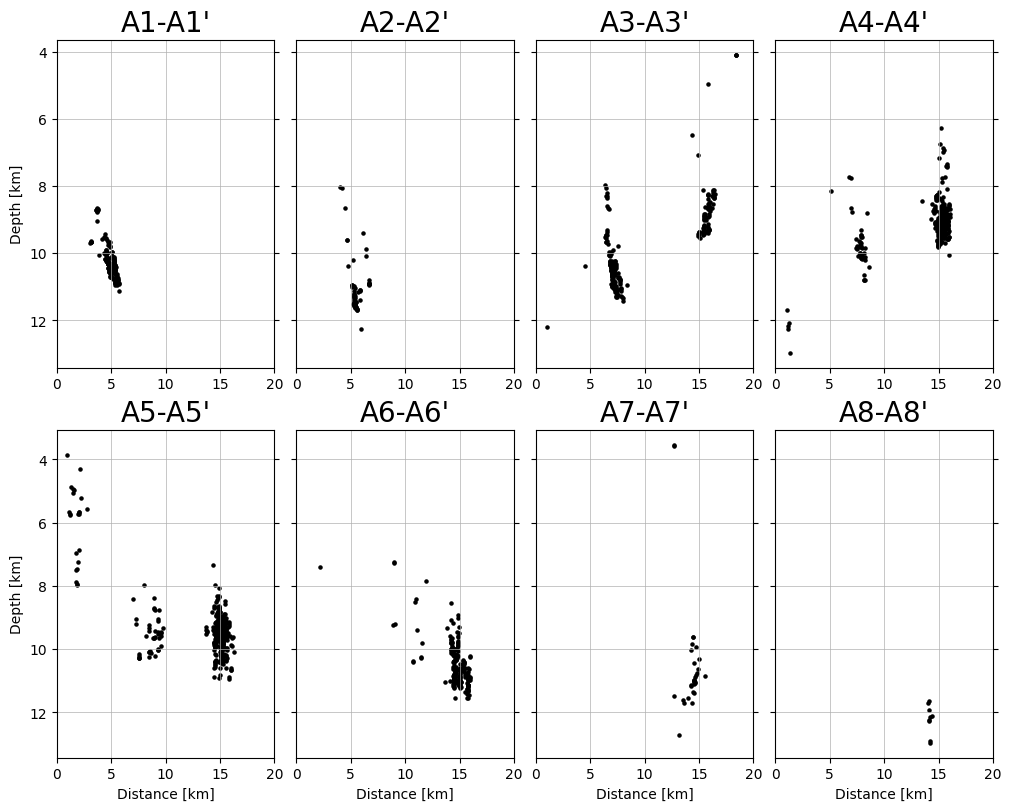

In [30]:
fig = plt.figure(figsize = (10, 8), layout = 'constrained')

gs = GridSpec(2, 4, figure = fig)

    # Subplots
        # Upper panel
ax1 = fig.add_subplot(gs[0, 0])
ax2 = fig.add_subplot(gs[0, 1], sharex = ax1, sharey = ax1)
ax3 = fig.add_subplot(gs[0, 2], sharex = ax1, sharey = ax1)
ax4 = fig.add_subplot(gs[0, 3], sharex = ax1, sharey = ax1)
        # Lower panel
ax5 = fig.add_subplot(gs[1, 0], sharex = ax1)
ax6 = fig.add_subplot(gs[1, 1], sharex = ax1, sharey = ax5)
ax7 = fig.add_subplot(gs[1, 2], sharex = ax1, sharey = ax5)
ax8 = fig.add_subplot(gs[1, 3], sharex = ax1, sharey = ax5)
    # Titles
ax1.set_title("A1-A1'" , fontsize = 20)
ax2.set_title("A2-A2'" , fontsize = 20)
ax3.set_title("A3-A3'" , fontsize = 20)
ax4.set_title("A4-A4'" , fontsize = 20)
ax5.set_title("A5-A5'" , fontsize = 20)
ax6.set_title("A6-A6'" , fontsize = 20)
ax7.set_title("A7-A7'" , fontsize = 20)
ax8.set_title("A8-A8'" , fontsize = 20)
    # x labels
        # Lower panel
ax5.set_xlabel('Distance [km]')
ax6.set_xlabel('Distance [km]')
ax7.set_xlabel('Distance [km]')
ax8.set_xlabel('Distance [km]')
    # y labels
        # Upper panel
ax1.set_ylabel('Depth [km]')
ax1.yaxis.set_ticks_position("both")
ax2.tick_params(labelleft = False)
ax2.yaxis.set_ticks_position("both")
ax3.tick_params(labelleft = False)
ax3.yaxis.set_ticks_position("both")
ax4.tick_params(labelleft = False)
ax4.yaxis.set_ticks_position("both")
        # Lower panel
ax5.set_ylabel('Depth [km]')
ax5.yaxis.set_ticks_position("both")
ax6.tick_params(labelleft = False)
ax6.yaxis.set_ticks_position("both")
ax7.tick_params(labelleft = False)
ax7.yaxis.set_ticks_position("both")
ax8.tick_params(labelleft = False)
ax8.yaxis.set_ticks_position("both")
    # x limns
ax1.set_xlim([0, 20])
    # y lims
        # Upper panel
# ax1.set_ylim([0, reloc_cat[:, 3].max()])
ax1.invert_yaxis()
        # Lower panel
# ax5.set_ylim([0, reloc_cat[:, 3].max()])
ax5.invert_yaxis()

    # Grid
        # Upper panel
ax1.grid(True, lw = 0.5)
ax2.grid(True, lw = 0.5)
ax3.grid(True, lw = 0.5)
ax4.grid(True, lw = 0.5)
ax5.grid(True, lw = 0.5)
ax6.grid(True, lw = 0.5)
ax7.grid(True, lw = 0.5)
ax8.grid(True, lw = 0.5)

# Plot data
    # A1
xz_data = np.genfromtxt(os.path.join(repo_fpath,'cross_section_data/A1.dat'), skip_header = 1, usecols = (8, 3))
ax1.scatter(xz_data[:, 0], xz_data[:, 1], color = 'k', s = 5)
    # A2
xz_data = np.genfromtxt(os.path.join(repo_fpath,'cross_section_data/A2.dat'), skip_header = 1, usecols = (8, 3))
ax2.scatter(xz_data[:, 0], xz_data[:, 1], color = 'k', s = 5)
    # A3
xz_data = np.genfromtxt(os.path.join(repo_fpath,'cross_section_data/A3.dat'), skip_header = 1, usecols = (8, 3))
ax3.scatter(xz_data[:, 0], xz_data[:, 1], color = 'k', s = 5)
    # A4
xz_data = np.genfromtxt(os.path.join(repo_fpath,'cross_section_data/A4.dat'), skip_header = 1, usecols = (8, 3))
ax4.scatter(xz_data[:, 0], xz_data[:, 1], color = 'k', s = 5)

    # A5
xz_data = np.genfromtxt(os.path.join(repo_fpath,'cross_section_data/A5.dat'), skip_header = 1, usecols = (8, 3))
ax5.scatter(xz_data[:, 0], xz_data[:, 1], color = 'k', s = 5)
    # A6
xz_data = np.genfromtxt(os.path.join(repo_fpath,'cross_section_data/A6.dat'), skip_header = 1, usecols = (8, 3))
ax6.scatter(xz_data[:, 0], xz_data[:, 1], color = 'k', s = 5)
    # A7
xz_data = np.genfromtxt(os.path.join(repo_fpath,'cross_section_data/A7.dat'), skip_header = 1, usecols = (8, 3))
ax7.scatter(xz_data[:, 0], xz_data[:, 1], color = 'k', s = 5)
    # A8
xz_data = np.genfromtxt(os.path.join(repo_fpath,'cross_section_data/A8.dat'), skip_header = 1, usecols = (8, 3))
ax8.scatter(xz_data[:, 0], xz_data[:, 1], color = 'k', s = 5)

fig.savefig(fname = os.path.join(repo_fpath,'figs/A_cross_sections.jpg'), dpi = 300)
fig.show()

*Cross sections B**

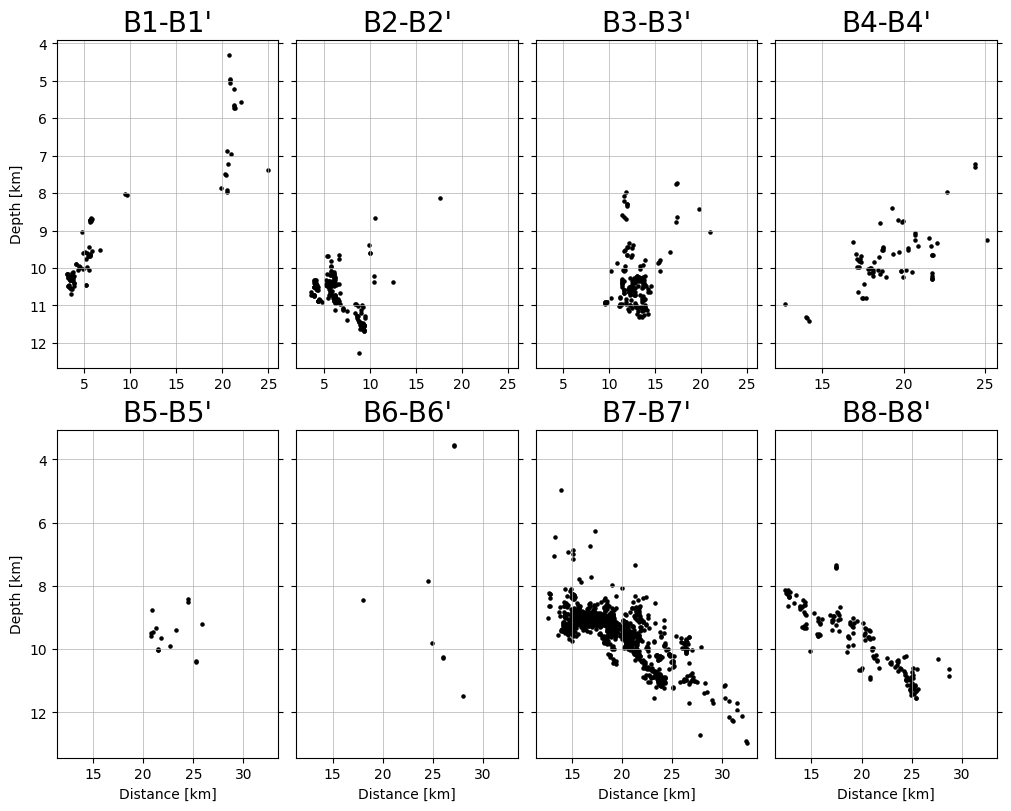

In [31]:
fig = plt.figure(figsize = (10, 8), layout = 'constrained')

gs = GridSpec(2, 4, figure = fig)

    # Subplots
        # Upper panel
ax1 = fig.add_subplot(gs[0, 0])
ax2 = fig.add_subplot(gs[0, 1], sharex = ax1, sharey = ax1)
ax3 = fig.add_subplot(gs[0, 2], sharex = ax1, sharey = ax1)
ax4 = fig.add_subplot(gs[0, 3], sharey = ax1)
        # Lower panel
ax5 = fig.add_subplot(gs[1, 0],)
ax6 = fig.add_subplot(gs[1, 1], sharex = ax5, sharey = ax5)
ax7 = fig.add_subplot(gs[1, 2], sharex = ax5, sharey = ax5)
ax8 = fig.add_subplot(gs[1, 3], sharex = ax5, sharey = ax5)
    # Titles
ax1.set_title("B1-B1'" , fontsize = 20)
ax2.set_title("B2-B2'" , fontsize = 20)
ax3.set_title("B3-B3'" , fontsize = 20)
ax4.set_title("B4-B4'" , fontsize = 20)
ax5.set_title("B5-B5'" , fontsize = 20)
ax6.set_title("B6-B6'" , fontsize = 20)
ax7.set_title("B7-B7'" , fontsize = 20)
ax8.set_title("B8-B8'" , fontsize = 20)
    # x labels
        # Lower panel
ax5.set_xlabel('Distance [km]')
ax6.set_xlabel('Distance [km]')
ax7.set_xlabel('Distance [km]')
ax8.set_xlabel('Distance [km]')
    # y labels
        # Upper panel
ax1.set_ylabel('Depth [km]')
ax1.yaxis.set_ticks_position("both")
ax2.tick_params(labelleft = False)
ax2.yaxis.set_ticks_position("both")
ax3.tick_params(labelleft = False)
ax3.yaxis.set_ticks_position("both")
ax4.tick_params(labelleft = False)
ax4.yaxis.set_ticks_position("both")
        # Lower panel
ax5.set_ylabel('Depth [km]')
ax5.yaxis.set_ticks_position("both")
ax6.tick_params(labelleft = False)
ax6.yaxis.set_ticks_position("both")
ax7.tick_params(labelleft = False)
ax7.yaxis.set_ticks_position("both")
ax8.tick_params(labelleft = False)
ax8.yaxis.set_ticks_position("both")
    # x limns
# ax1.set_xlim([0, 20])
    # y lims
        # Upper panel
# ax1.set_ylim([0, reloc_cat[:, 3].max()])
ax1.invert_yaxis()
        # Lower panel
# ax5.set_ylim([0, reloc_cat[:, 3].max()])
ax5.invert_yaxis()

    # Grid
        # Upper panel
ax1.grid(True, lw = 0.5)
ax2.grid(True, lw = 0.5)
ax3.grid(True, lw = 0.5)
ax4.grid(True, lw = 0.5)
ax5.grid(True, lw = 0.5)
ax6.grid(True, lw = 0.5)
ax7.grid(True, lw = 0.5)
ax8.grid(True, lw = 0.5)

# Plot data
    # B1
xz_data = np.genfromtxt(os.path.join(repo_fpath,'cross_section_data/B1.dat'), skip_header = 1, usecols = (8, 3))
ax1.scatter(xz_data[:, 0], xz_data[:, 1], color = 'k', s = 5)
    # B2
xz_data = np.genfromtxt(os.path.join(repo_fpath,'cross_section_data/B2.dat'), skip_header = 1, usecols = (8, 3))
ax2.scatter(xz_data[:, 0], xz_data[:, 1], color = 'k', s = 5)
    # B3
xz_data = np.genfromtxt(os.path.join(repo_fpath,'cross_section_data/B3.dat'), skip_header = 1, usecols = (8, 3))
ax3.scatter(xz_data[:, 0], xz_data[:, 1], color = 'k', s = 5)
    # B4
xz_data = np.genfromtxt(os.path.join(repo_fpath,'cross_section_data/B4.dat'), skip_header = 1, usecols = (8, 3))
ax4.scatter(xz_data[:, 0], xz_data[:, 1], color = 'k', s = 5)

    # B5
xz_data = np.genfromtxt(os.path.join(repo_fpath,'cross_section_data/B5.dat'), skip_header = 1, usecols = (8, 3))
ax5.scatter(xz_data[:, 0], xz_data[:, 1], color = 'k', s = 5)
    # B6
xz_data = np.genfromtxt(os.path.join(repo_fpath,'cross_section_data/B6.dat'), skip_header = 1, usecols = (8, 3))
ax6.scatter(xz_data[:, 0], xz_data[:, 1], color = 'k', s = 5)
    # B7
xz_data = np.genfromtxt(os.path.join(repo_fpath,'cross_section_data/B7.dat'), skip_header = 1, usecols = (8, 3))
ax7.scatter(xz_data[:, 0], xz_data[:, 1], color = 'k', s = 5)
    # B8
xz_data = np.genfromtxt(os.path.join(repo_fpath,'cross_section_data/B8.dat'), skip_header = 1, usecols = (8, 3))
ax8.scatter(xz_data[:, 0], xz_data[:, 1], color = 'k', s = 5)

fig.savefig(fname = os.path.join(repo_fpath,'figs/B_cross_sections.jpg'), dpi = 300)
fig.show()